In [90]:
# imports
# eda
import gzip
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# model
import random
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import gc

In [9]:
def parse_gz(path):

    with gzip.open(path, "rt", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            yield ast.literal_eval(line)

In [194]:
def build_user_game_df(path):
    """
    Flatten the raw user-level data into a user–game table.

    Output columns:
        user_id, item_id, item_name,
        playtime_forever, playtime_2weeks
    """
    rows = []

    for user in parse_gz(path):
        uid   = str(user.get("user_id"))
        items = user.get("items", [])

        # one row per (user, game) pair
        for item in items:
            item_id = str(item.get("item_id"))
            item_name = item.get("item_name")
            
            rows.append(
                {
                    "user_id": uid,
                    "item_id": item_id,
                    "item_name": item_name,
                    "playtime_forever": item.get("playtime_forever"),
                    "playtime_2weeks": item.get("playtime_2weeks"),
                    "purchase": 1,
                }
            )

            item_name_lookup[item_id] = item_name

    df = pd.DataFrame(rows)
    return df

In [202]:
def clean_user_game_df(df, min_games_per_user=2):
    """
    Clean the user–game DataFrame for the 'missing game' task.
    - Keep zero-playtime games (they are still a part of the user's library).
    - Drop rows with missing game IDs or missing playtime.
    - Drop negative playtime.
    - Deduplicate (user_id, item_id).
    - Keep only users with at least `min_games_per_user` games.
    """

    # make sure playtime columns are numeric
    for col in ["playtime_forever", "playtime_2weeks"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # must have a game ID, name, and playtime_forever
    df = df.dropna(subset=["item_id", "item_name", "playtime_forever"])

    # impossible values
    df = df[df["playtime_forever"] >= 0]

    # delete the duplicate user–game pairs (keep largest playtime)
    df = (
        df.sort_values("playtime_forever")
          .drop_duplicates(subset=["user_id", "item_id"], keep="last")
    )

    # require at least 2 games per user (otherwise 'missing game' not defined)
    games_per_user = df.groupby("user_id")["item_id"].nunique()
    valid_users = games_per_user[games_per_user >= min_games_per_user].index
    df = df[df["user_id"].isin(valid_users)].copy()

    # convenience flags
    df["owns_game"] = 1
    df["never_played"] = df["playtime_forever"] <= 0

    return df

In [238]:
def predict_buy_and_never_play(user_id, item_id):
    """
    Returns probability that the user will:
    (1) Buy the item
    (2) Never play it after buying
    """
    if item_id not in item_vecs:
        return None  # unknown item

    vec = item_vecs[item_id]
    pop = item_pop.get(item_id, 0)
    unr = user_never_rate.get(user_id, 0)

    feats = np.array(list(vec) + [pop, unr]).reshape(1, -1)

    p_buy = clf_buy.predict_proba(feats)[0, 1]
    p_never = clf_never.predict_proba(feats)[0, 1]

    return p_buy * p_never

In [96]:
# inits
random.seed(42)
item_name_lookup = {}

# 1: Task
- Steam is a video game platform for computer video games. You can buy and play games on the platform. The platform also logs how long you play a game for.
- The task is to predict whether or not a Steam user user will buy a game and not play it
- Since the number of games is very large, our baseline trivially predicts that all users won't buy (and implicitly doesn't play) any games.
- The model will be validated via training and test splits on the data. The model should hopefully perform better than the baseline.

# 2: Exploratory Data Analysis, Data Collection, and EDA Preprocessing
- Data is from the [assignment 1 datasets](https://cseweb.ucsd.edu/~jmcauley/datasets.html). It records users, their owned games, and playtime for each game. The data was scraped around 2017.

In [204]:
# get data
df_raw = build_user_game_df("australian_users_items.json.gz")
print("Number of raws rows (user–game pairs):", len(df_raw))
df_raw.head()

Number of raws rows (user–game pairs): 5153209


,user_id,item_id,item_name,playtime_forever,playtime_2weeks,purchase
0,76561197970982479,10,Counter-Strike,6,0,1
1,76561197970982479,20,Team Fortress Classic,0,0,1
2,76561197970982479,30,Day of Defeat,7,0,1
3,76561197970982479,40,Deathmatch Classic,0,0,1
4,76561197970982479,50,Half-Life: Opposing Force,0,0,1


In [210]:
# clean data
df_eda = clean_user_game_df(df_raw, min_games_per_user=0) # changed changed min games from 2 (from eda) to 0
print("Number of rows after cleaning", len(df))
df.head()

Number of rows after cleaning 5094082


,user_id,steam_id,item_id,item_name,playtime_forever,playtime_2weeks,owns_game,ever_played,playtime_share
3721801,xinyo,76561197990718796,94590,Puzzle Agent 2,0,0,1,False,0.0
3335155,76561198073798725,76561198073798725,227940,Heroes & Generals,0,0,1,False,0.0
3335156,76561198073798725,76561198073798725,323370,TERA,0,0,1,False,0.0
1247907,teh_pwning_dude,76561197971373696,65790,Arma: Cold War Assault,0,0,1,False,0.0
3335159,76561198073798725,76561198073798725,333930,Dirty Bomb,0,0,1,False,0.0


In [56]:
# basic data stats
n_users = df_eda["user_id"].nunique()
n_games = df_eda["item_id"].nunique()
n_interactions = len(df)

print("=== Basic dataset statistics ===")
print(f"Number of users who have two or more games:     {n_users}")
print(f"Number of games in total:                       {n_games}")
print(f"User–game interactions:                         {n_interactions}")

=== Basic dataset statistics ===
Number of users who have two or more games:     70912
Number of games in total:                       10978
User–game interactions:                         5094082


=== Games per user (summary) ===
count    70912.000000
mean        71.836671
std        132.366763
min          1.000000
25%         14.000000
50%         40.000000
75%         87.000000
max       7762.000000
Name: item_id, dtype: float64


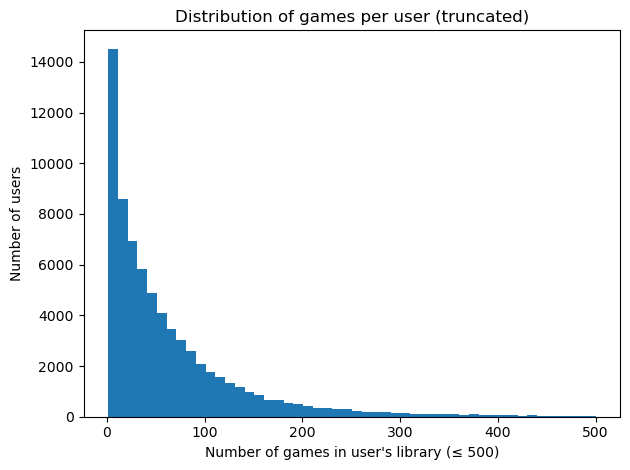

In [59]:
# games per user graph and stats
games_per_user = df_eda.groupby("user_id")["item_id"].nunique()

print("=== Games per user (summary) ===")
print(games_per_user.describe())

plt.figure()

# the max game library is 7762 but we omit it for the visualization so the graph has a reasonable scale
mask = games_per_user <= 500    # keep only "reasonable" library sizes
plt.hist(games_per_user[mask], bins=50)

plt.xlabel("Number of games in user's library (≤ 500)")
plt.ylabel("Number of users")
plt.title("Distribution of games per user (truncated)")
plt.tight_layout()
plt.show()

=== Users per game (summary) ===
count    10978.000000
mean       464.026416
std       1793.593696
min          1.000000
25%          9.000000
50%         43.000000
75%        220.000000
max      49136.000000
Name: user_id, dtype: float64


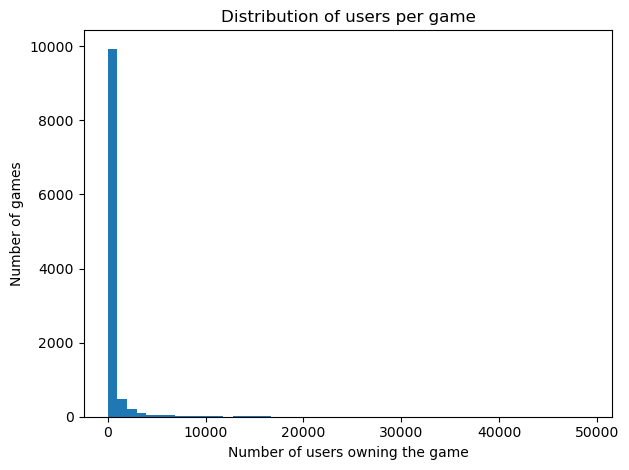

=== Top 10 most owned games ===
item_id  item_name                       
205790   Dota 2 Test                         49136
730      Counter-Strike: Global Offensive    43331
4000     Garry's Mod                         42849
304930   Unturned                            38278
223530   Left 4 Dead 2 Beta                  36661
550      Left 4 Dead 2                       36661
105600   Terraria                            28934
230410   Warframe                            25516
620      Portal 2                            24206
240      Counter-Strike: Source              23952
Name: user_id, dtype: int64


In [61]:
# users per game graph and stats
users_per_game = df_eda.groupby("item_id")["user_id"].nunique()

print("=== Users per game (summary) ===")
print(users_per_game.describe())

plt.figure()
plt.hist(users_per_game, bins=50)
plt.xlabel("Number of users owning the game")
plt.ylabel("Number of games")
plt.title("Distribution of users per game")
plt.tight_layout()
plt.show()

# Top 10 most owned games
top_owned = (
    df_eda.groupby(["item_id", "item_name"])["user_id"]
      .nunique()
      .sort_values(ascending=False)
      .head(10)
)

print("=== Top 10 most owned games ===")
print(top_owned)

=== Playtime forever (minutes) summary ===
count    5.094082e+06
mean     9.905071e+02
std      5.414098e+03
min      0.000000e+00
25%      0.000000e+00
50%      3.400000e+01
75%      3.550000e+02
max      6.427730e+05
Name: playtime_forever, dtype: float64


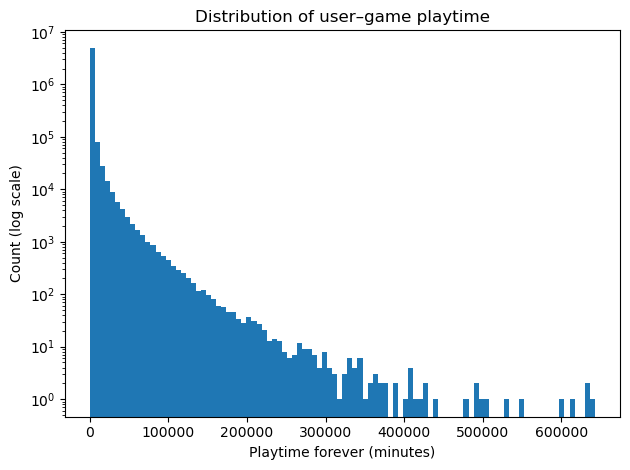

In [62]:
# playtime distribution
print("=== Playtime forever (minutes) summary ===")
print(df_eda["playtime_forever"].describe())

plt.figure()
plt.hist(df_eda["playtime_forever"], bins=100)
plt.yscale("log")  # heavy tail, log y-axis makes it readable
plt.xlabel("Playtime forever (minutes)")
plt.ylabel("Count (log scale)")
plt.title("Distribution of user–game playtime")
plt.tight_layout()
plt.show()

In [63]:
# total playtime per game
total_time_per_game = (
    df_eda.groupby(["item_id", "item_name"])["playtime_forever"]
      .sum()
      .sort_values(ascending=False)
)

# get top 10
top10_time = total_time_per_game.head(10)

# convert minutes to hours for readability
top10_hours = (top10_time / 60).round(1)

print("=== Top 10 games by total playtime (all users combined) ===")
for (item_id, item_name), hours in top10_hours.items():
    print(f"{item_name:40s}  (id={item_id})  total hours = {hours:.1f}")

=== Top 10 games by total playtime (all users combined) ===
Counter-Strike: Global Offensive          (id=730)  total hours = 12929747.5
Garry's Mod                               (id=4000)  total hours = 7364517.1
Terraria                                  (id=105600)  total hours = 2549960.7
The Elder Scrolls V: Skyrim               (id=72850)  total hours = 2247524.2
Warframe                                  (id=230410)  total hours = 2045447.6
Counter-Strike: Source                    (id=240)  total hours = 1855245.1
Left 4 Dead 2                             (id=550)  total hours = 1686523.6
PAYDAY 2                                  (id=218620)  total hours = 1640096.4
Sid Meier's Civilization V                (id=8930)  total hours = 1353123.5
Rust                                      (id=252490)  total hours = 1335168.9


=== Time concentration across user libraries ===
Median share of time in top 1 game: 0.372
Median share of time in top 5 games: 0.799


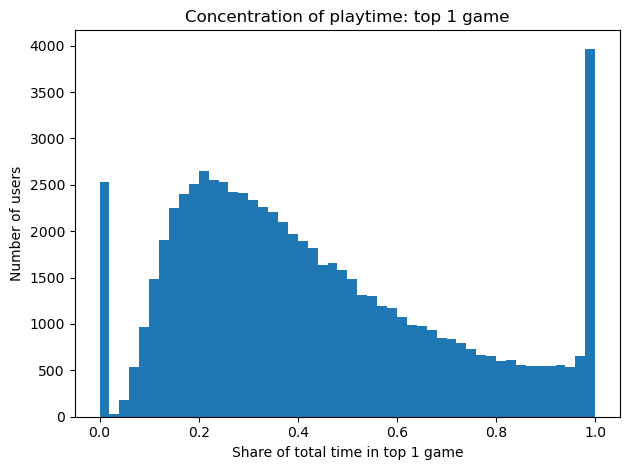

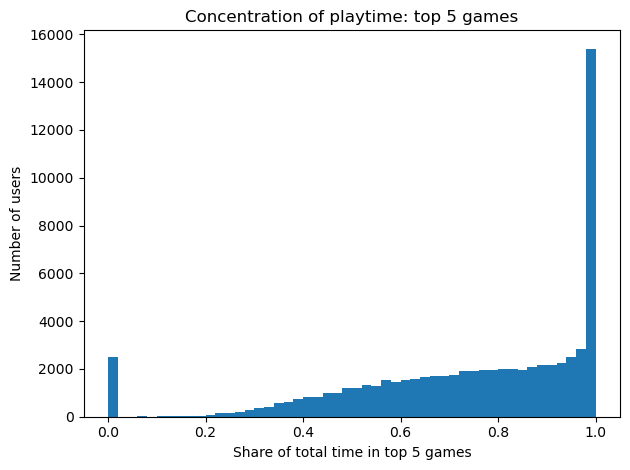

In [67]:
# total playtime per user
user_total_time = df_eda.groupby("user_id")["playtime_forever"].transform("sum")
df_eda["playtime_share"] = np.where(
    user_total_time > 0,
    df_eda["playtime_forever"] / user_total_time,
    0.0,
)

def top_k_share(s, k):
    # s is a Series of playtime_share for one user
    shares = s.sort_values(ascending=False)
    return shares.head(k).sum()

# group only the column you care about
top1 = df_eda.groupby("user_id")["playtime_share"].apply(top_k_share, k=1)
top5 = df_eda.groupby("user_id")["playtime_share"].apply(top_k_share, k=5)

print("=== Time concentration across user libraries ===")
print(f"Median share of time in top 1 game: {top1.median():.3f}")
print(f"Median share of time in top 5 games: {top5.median():.3f}")

plt.figure()
plt.hist(top1, bins=50)
plt.xlabel("Share of total time in top 1 game")
plt.ylabel("Number of users")
plt.title("Concentration of playtime: top 1 game")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(top5, bins=50)
plt.xlabel("Share of total time in top 5 games")
plt.ylabel("Number of users")
plt.title("Concentration of playtime: top 5 games")
plt.tight_layout()
plt.show()

In [211]:
# fraction of users who've never played a game
frac_never_played = df_eda["never_played"].mean()
print("=== Ever played vs never played ===")
print(f"Fraction of user–game pairs with zero playtime: {frac_never_played:.3f}")

=== Ever played vs never played ===
Fraction of user–game pairs with zero playtime: 0.363


In [69]:
# find the number of users who don't own a game
# games per user in the RAW data
games_per_user_raw = df_raw.groupby("user_id")["item_id"].nunique()

# users who only own less than 2 games
one_game_users = games_per_user_raw[games_per_user_raw < 2]

print("Number of users less than 2 games:", len(one_game_users))
print("Share of all users:", len(one_game_users) / len(games_per_user_raw))

Number of users less than 2 games: 3303
Share of all users: 0.0465788583032491


# 2.5: Modeling Preprocessing

In [214]:
df_ui = clean_user_game_df(df_raw, min_games_per_user=0) # changed changed min games from 2 (from eda) to 0

In [220]:
# build samples of user, games where user hasn't purchased the game
all_items = set(df_ui["item_id"].unique())

neg_samples = []

for user, group in tqdm(df_ui.groupby("user_id")):
  purchased = set(group["item_id"])
  not_bought = list(all_items - purchased)

  # sample 20 unbought games per user
  sample_count = min(20, len(not_bought))
  sampled_items = random.sample(not_bought, sample_count)

  for item in sampled_items:
    neg_samples.append({
        "user_id": user,
        "item_id": item,
        "item_name": item_name_lookup[item],
        "playtime_forever": 0,
        "purchase": 0,
        "never_played": 1
    })

df_neg = pd.DataFrame(neg_samples)

df_neg.head()

100%|██████████████████████████████████████████████████████████████████████████| 70912/70912 [00:30<00:00, 2310.16it/s]


,user_id,item_id,item_name,playtime_forever,purchase,never_played
0,--000--,265400,FX Football - The Manager for Every Football Fan,0,0,1
1,--000--,253130,Rescue: Everyday Heroes,0,0,1
2,--000--,299640,Afterfall: Reconquest Episode I,0,0,1
3,--000--,453270,Madness Cubed,0,0,1
4,--000--,210490,Fray,0,0,1


In [221]:
# merge positive and negative samples together
df_full = pd.concat([df_ui, df_neg], ignore_index = True)

df_full["target_buy"] = df_full["purchase"]
df_full["target_never"] = df_full["never_played"]

df_full.head()

,user_id,item_id,item_name,playtime_forever,playtime_2weeks,purchase,owns_game,never_played,target_buy,target_never
0,xinyo,94590,Puzzle Agent 2,0,0.0,1,1.0,1,1,1
1,76561198073798725,227940,Heroes & Generals,0,0.0,1,1.0,1,1,1
2,76561198073798725,323370,TERA,0,0.0,1,1.0,1,1,1
3,teh_pwning_dude,65790,Arma: Cold War Assault,0,0.0,1,1.0,1,1,1
4,76561198073798725,333930,Dirty Bomb,0,0.0,1,1.0,1,1,1


In [224]:
# build purchase sequences per user and train a corresponding word2vec
user_sequences = (
    df_ui[df_ui["purchase"] == 1]
    .groupby("user_id")["item_id"]
    .apply(list)
    .tolist()
)

item2vec = Word2Vec(
    sentences=user_sequences,
    vector_size=64,
    window=10,
    min_count=1,
    workers=4,
    sg=1,
)

# # how many items got vectors
# print(len(item2vec.wv))
# print(df_ui['item_id'].nunique())

# # should be 64
# print(item2vec.wv.vector_size)              
# print(item2vec.wv.most_similar(0))

In [228]:
# add vec to df
item_vecs = {item: item2vec.wv[item] for item in item2vec.wv.index_to_key}
df_full["item_vec"] = df_full["item_id"].map(item_vecs)
df_full = df_full[df_full["item_vec"].notna()]

# expand
for i in range(64):
    df_full[f"v{i}"] = df_full["item_vec"].apply(lambda x: x[i])

In [231]:
# build extra features
# note that clean_user_game_df() already added an never_played column for each interaction
# some interesting notes
    # adding the 2 week playtime (and any temporal features) hurt the model. 2 week tendencies might not add meaningful information to our task 
    # possibly adds noise (as the information is related to "playtime_forever")

# game popularity
item_pop = df_ui.groupby("item_id")["playtime_forever"].count()

# rate of user not playing
user_never_rate = df_ui.groupby("user_id")["never_played"].mean()

df_full["item_popularity"] = df_full["item_id"].map(item_pop)
df_full["user_never_rate"] = df_full["user_id"].map(user_never_rate)

# Fill NaNs (should be few)
df_full["item_popularity"] = df_full["item_popularity"].fillna(0)
df_full["user_never_rate"] = df_full["user_never_rate"].fillna(0)

# 3: Modeling
- To verify the taks, we will split the data into train and test splits. The model will have to predict the `buy_and_never` label from the given features. The features are `playtime_forever`, `playtime_2weeks`, whether or not they `purchased` and/or `owns_game`, and `never_played`.


In [237]:
%%time

# train stage 1 model (whether or not the user would buy the game)
features = [f"v{i}" for i in range(64)] + ["item_popularity", "user_never_rate"]
X = df_full[features].values
y = df_full["target_buy"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y
)

clf_buy = LogisticRegression(max_iter=2500, C=1.0)
clf_buy.fit(X_train, y_train)

print("\n===== Stage 1: Buy Prediction Model =====")
pred = clf_buy.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))
# print("F1:", f1_score(y_test, pred))
# print(confusion_matrix(y_test, pred))
print(f"num iter: {clf_buy.n_iter_}")


===== Stage 1: Buy Prediction Model =====
Accuracy: 0.8915364328408057
num iter: [920]
CPU times: total: 19min 44s
Wall time: 3min 46s


In [247]:
%%time
# train stage 2 Model (predict whether or not the user will play the bought game)

purchased_df = df_full[df_full["purchase"] == 1]

X2 = purchased_df[features].values
y2 = purchased_df["target_never"].values

# Split inside the purchased buyers only
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

clf_never = LogisticRegression(max_iter=6000)
clf_never.fit(X2_train, y2_train)

print("\n===== Stage 2: NEVER PLAY MODEL =====")
pred2 = clf_never.predict(X2_test)
print("Accuracy:", accuracy_score(y2_test, pred2))
# print("F1:", f1_score(y2_test, pred2))
# print(confusion_matrix(y2_test, pred2))
print(f"num iter: {clf_never.n_iter_}")


===== Stage 2: NEVER PLAY MODEL =====
Accuracy: 0.8007767832692231
num iter: [1944]


In [252]:
test_data = df_full[["user_id", "item_id", "target_buy", "target_never"]].copy()
test_data["buy_and_never"] = test_data["target_buy"] * test_data["target_never"]

# # Step 1 — take only 20% of test_data
# test_sample = test_data.sample(frac=0.10, random_state=42)

# # Step 2 — shuffle the sampled rows
# test_sample = test_sample.sample(frac=1, random_state=1337).reset_index(drop=True)

# test_sample

In [254]:
%%time
# get users and items
uids = test_data["user_id"].values
iids = test_data["item_id"].values

probs = np.empty(len(test_data), dtype=float)

# predict all pairs
for i in range(len(test_data)):
    p = predict_buy_and_never_play(uids[i], iids[i])
    probs[i] = np.nan if p is None else p

test_data["prob"] = probs
test_eval = test_data.dropna(subset=["prob"]).reset_index(drop=True)
test_eval

CPU times: total: 9min 26s
Wall time: 9min 35s


,user_id,item_id,target_buy,target_never,buy_and_never,prob
0,xinyo,94590,1,1,1,0.963420
1,76561198073798725,227940,1,1,1,0.122531
2,76561198073798725,323370,1,1,1,0.228176
3,teh_pwning_dude,65790,1,1,1,0.676878
4,76561198073798725,333930,1,1,1,0.127930
...,...,...,...,...,...,...
6512317,zzzmidmiss,228940,0,1,0,0.047483
6512318,zzzmidmiss,348450,0,1,0,0.056807
6512319,zzzmidmiss,356090,0,1,0,0.075337
6512320,zzzmidmiss,369200,0,1,0,0.217178


In [263]:
# thresholds = np.linspace(0, 1, 101)   # 0.00, 0.01, ..., 1.00
thresholds = [0.49] # best

best_f1 = -1
best_thr_f1 = None

results = []   # optional: store all results

y_true = test_eval["buy_and_never"].values
probs   = test_eval["prob"].values

for thr in thresholds:
    y_pred = (probs >= thr).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, zero_division=0)

    results.append((thr, acc, f1))

    if acc > best_acc:
        best_acc = acc
        best_thr_acc = thr

    if f1 > best_f1:
        best_f1 = f1
        best_thr_f1 = thr

print("\n===== BEST F1 THRESHOLD =====")
print("Threshold:", best_thr_f1)
print("F1:", best_f1)


===== BEST F1 THRESHOLD =====
Threshold: 0.49
F1: 0.6387864984555841


In [265]:
# baseline predictions (always predict never buy)
y_pred = np.zeros_like(y_true, dtype=int)

baseline_f1  = f1_score(y_true, y_pred, zero_division=0)

print("===== BASELINE: ALWAYS 'NEVER BUY' =====")
print("F1:", baseline_f1)

===== BASELINE: ALWAYS 'NEVER BUY' =====
F1: 0.0


# 4 - Evaluation    
- We are optimizing the F1 as it is a compromise between accuracy and precision.
    - Accuracy is important since we care about how correct our predictions are. We can't only use accuracy because since we have class imbalance, as the rate of buying a game and not playing it is lower than other outcomes. A large chunk of the accuracy score can come from purely guessing whether or not a user has a game, ignoring the playtime condition.
    - Precision is important because we also care about how often our positive cases are actually positive. We can't only use precision because it can be exploited by only predicting positive in the most obvious cases.
    - We are only printing accuracy for each models as debugging info to make sure nothing is going wrong. The final result is measured in F1